In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
# from SZstacker import SZMapStacker # type: ignore
from stacker import SimulationStacker
from loadIO import load_data    
from utils import fft_smoothed_map, gaussian_smoothed_map
from utils import ksz_from_delta_sigma, arcmin_to_comoving, comoving_to_arcmin


# sys.path.append('../../illustrisPython/')
import illustris_python as il # type: ignore

import yaml
import argparse
from pathlib import Path
import glob

In [3]:
# simPath = '/global/cfs/cdirs/m3363/rhliu/Simulations/'
# sim = 'TNG100-1'
# sim_type_name = 'IllustrisTNG'
sim = 'm50n512'
feedback = 's50'
sim_type_name = 'SIMBA'
# simPath = '/pscratch/sd/r/rhliu/simulations/SIMBA/' + sim + '/output/'

In [4]:
stacker = SimulationStacker(sim, 125, 10, sim_type_name, z=0.5, feedback=feedback)

In [5]:
map1 = stacker.makeField('ionized_gas', nPixels=20, load=False)#, mask=True, maskRad=100.0)
map2 = stacker.makeField('tau', nPixels=20, load=False)#, mask=True, maskRad=100.0)

Snaps: ['/pscratch/sd/r/rhliu/simulations/SIMBA/m50n512/s50/snapshots/snap_m50n512_125.hdf5']
Processed 0 snapshots, time elapsed: 16.82 seconds
Binned statistic time: 16.821725845336914
Processed 0 snapshots, time elapsed: 22.39 seconds
hist2d time: 22.39523148536682


In [8]:
map3 = ksz_from_delta_sigma(map1 * u.Msun / u.kpc**2 * stacker.header['HubbleParam'], stacker.z, stacker.cosmo, delta_sigma_is_comoving=False)

TypeError: unsupported operand type(s) for /: 'FlatLambdaCDM' and 'float'

In [5]:
(map1/map2)

array([[5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704504e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16],
       [5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704504e+16, 5.58704504e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704506e+16, 5.58704505e+16, 5.58704505e+16],
       [5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.58704504e+16,
        5.58704504e+16, 5.58704504e+16, 5.58704505e+16, 5.58704505e+16,
        5.58704505e+16, 5.58704505e+16, 5.58704505e+16, 5.5870

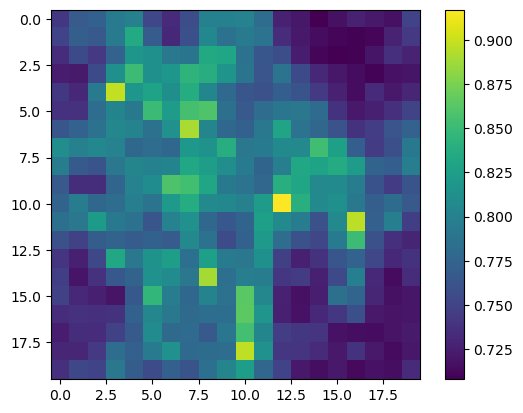

In [9]:
plt.imshow(map1/map2)
plt.colorbar()

In [ ]:
pType = 'ionized_gas'

map1 = stacker.makeField(pType, nPixels=20, load=False)#, mask=True, maskRad=100.0)
map2 = stacker.makeField(pType, nPixels=20, load=False)#, mask=True, maskRad=100.0)

Snaps: ['/pscratch/sd/r/rhliu/simulations/SIMBA/m50n512/s50/snapshots/snap_m50n512_125.hdf5']
Processed 0 snapshots, time elapsed: 15.81 seconds
Binned statistic time: 15.809123277664185
Snaps: ['/pscratch/sd/r/rhliu/simulations/SIMBA/m50n512/s50/snapshots/snap_m50n512_125.hdf5']
Processed 0 snapshots, time elapsed: 15.35 seconds
Binned statistic time: 15.35302209854126


In [11]:
from loadIO import snap_path, load_halos, load_subsets, load_subset, load_data, save_data

In [12]:
folderPath = stacker.snapPath(stacker.simType, pathOnly=True) # type: ignore
if stacker.simType == 'IllustrisTNG':
    snaps = glob.glob(folderPath + 'snap_*.hdf5') # TODO: fix this for SIMBA (done I think)
elif stacker.simType == 'SIMBA':
    # print('Folder Path:', folderPath + f'*_{stacker.snapshot}.hdf5')
    snaps = glob.glob(folderPath)

snap = snaps[0]

In [15]:
keys = ['Coordinates', 'Masses', 'ElectronAbundance'] 
pType = 'gas'
particles = load_subset(stacker.simPath, stacker.snapshot, stacker.simType, pType, 
                        snap_path=snap, header=stacker.header, sim_name=stacker.sim,
                        keys=keys)

In [22]:
particles['ElectronAbundance']

solar_mass = 1.989e33 # g
m_p = 1.6726e-24 # g, mass of proton
X_H = 0.76 # unitless, primordial hydrogen fraction
h = stacker.header['HubbleParam'] # Hubble Parameter

Mgas_g = particles['Masses']  * 1e10 #* (solar_mass / h) # convert to grams
xe = particles['ElectronAbundance']
Ne = xe * X_H * Mgas_g / m_p # dimensionless count of electrons
mu_e = 2.0 / (1.0 + X_H)

Mion_e_g = Ne * m_p * mu_e # grams of ionized gas
masses = Mion_e_g #* (h / solar_mass) # convert back to Msun/h

In [29]:
1e10 * solar_mass / h * particles['Masses']

array([3.62878399e+40, 3.62878399e+40, 3.62878399e+40, ...,
       4.08808093e+40, 3.73335030e+40, 4.13727273e+40])

In [32]:
particles['Masses'].astype(np.float64) * 1e10 * solar_mass / h

array([3.62878399e+40, 3.62878399e+40, 3.62878399e+40, ...,
       4.08808093e+40, 3.73335030e+40, 4.13727273e+40])

In [19]:
Mgas_g

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

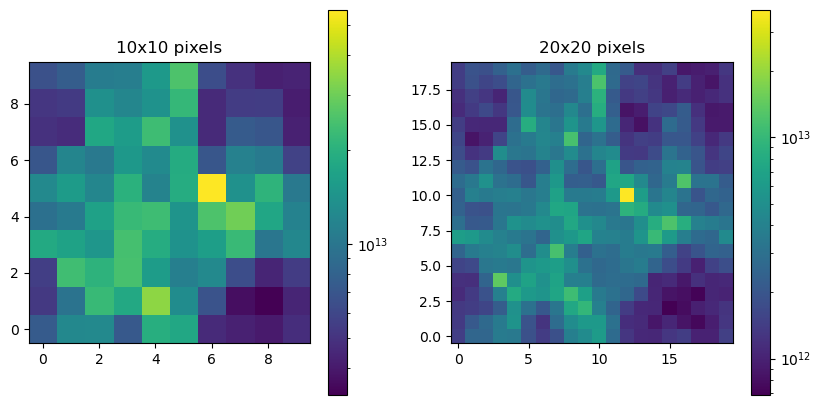

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax[0].imshow(map1, origin='lower', norm=LogNorm())
fig.colorbar(im1, ax=ax[0])
ax[0].set_title('10x10 pixels')
im2 = ax[1].imshow(map2, origin='lower', norm=LogNorm())
fig.colorbar(im2, ax=ax[1])
ax[1].set_title('20x20 pixels')
plt.show()

In [8]:
print(map1.sum(), map2.sum())

2.8933973992037468e-08 2.8933973992037746e-08


In [9]:
map1

array([[6.74600626e-11, 1.37512881e-10, 1.69002937e-10, 5.76618487e-11,
        3.93758423e-10, 3.04983367e-10, 2.96444006e-11, 5.87499142e-13,
        5.86988564e-12, 1.94178762e-11],
       [2.26702863e-11, 1.29781036e-10, 4.37084708e-10, 3.89453345e-10,
        8.49890143e-10, 1.91105907e-10, 7.30176865e-11, 1.12270062e-11,
        6.74321797e-12, 1.43835520e-11],
       [2.01338227e-11, 8.27631470e-10, 4.70745613e-10, 5.83336273e-10,
        2.75659654e-10, 1.17954904e-10, 1.68828331e-10, 5.25604910e-11,
        9.35912305e-12, 3.47199648e-11],
       [3.12568641e-10, 2.90571238e-10, 2.01429494e-10, 5.62261971e-10,
        3.31617441e-10, 1.78580277e-10, 3.18331609e-10, 5.41681964e-10,
        6.54293577e-11, 1.56765632e-10],
       [1.26734776e-10, 1.08850923e-10, 2.99719870e-10, 4.62574042e-10,
        4.92691582e-10, 2.25774222e-10, 1.14278957e-09, 7.29045103e-10,
        2.47682286e-10, 1.18147418e-10],
       [1.56767245e-10, 2.64478223e-10, 1.64426789e-10, 3.84897412e-10,
   